In [ ]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()


  Activating project at `~/Library/CloudStorage/OneDrive-stud.tu-darmstadt.de/TUDarmstadt/Vierte/lectures/OptimalControl/cmu/lecture-notebooks-2025/Lecture 13`


In [ ]:
using LinearAlgebra      # 线性代数运算
using PyPlot            # 绘图工具
using ForwardDiff       # 自动微分（用于计算梯度和雅可比矩阵）
using RobotZoo          # 机器人动力学模型库
const RZ = RobotZoo     # 简化引用
using RobotDynamics     # 机器人动力学
using Ipopt             # 内点法非线性规划求解器
using MathOptInterface  # 数学优化接口
const MOI = MathOptInterface;


In [ ]:
# 定义机器人系统 - Acrobot（双摆系统）
a = RobotZoo.Acrobot()  # 创建Acrobot模型
h = 0.1                 # 采样时间间隔，对应10Hz频率


0.1

In [ ]:
# 优化问题参数设置
Nx = 4              # 状态变量维数：[θ1, θ2, θ̇1, θ̇2]
Nu = 1              # 控制变量维数：关节扭矩
Tfinal = 5.0        # 最终时间
Nt = Int(Tfinal/h)+1    # 时间步数
thist = Array(range(0,h*(Nt-1), step=h));  # 时间历程数组
n_nlp = (Nx+Nu)*Nt      # 非线性规划决策变量总数
m_nlp = Nx*(Nt+1)       # 约束条件总数

208

In [ ]:
# 直接配点法动力学约束函数（使用Hermite-Simpson积分）
function dircol_dynamics(x1,u1,x2,u2)
    # 基于Hermite-Simpson积分的配点约束，控制输入采用一阶保持
    f1 = RZ.dynamics(a, x1, u1)    # 时刻k的动力学
    f2 = RZ.dynamics(a, x2, u2)    # 时刻k+1的动力学
    xm = 0.5*(x1 + x2) + (h/8.0)*(f1 - f2)    # 中点状态
    um = 0.5*(u1 + u2)                         # 中点控制输入
    ẋm = (-3/(2.0*h))*(x1 - x2) - 0.25*(f1 + f2)  # 中点导数
    fm = RZ.dynamics(a, xm, um)                # 中点动力学
    return fm - ẋm  # 返回配点约束残差
end

dircol_dynamics (generic function with 1 method)

In [29]:
# 成本函数权重矩阵
Q = Diagonal([1.0*ones(2); 1.0*ones(2)]);  # 状态权重矩阵（角度和角速度）
R = 0.1;                                    # 控制权重

# 单步成本函数
function stage_cost(x,u)
    # 二次型成本：状态偏差成本 + 控制成本
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5*u'*R*u
end

# 总成本函数
function cost(ztraj)
    z = reshape(ztraj,Nx+Nu,Nt)  # 重塑为状态-控制轨迹矩阵
    J = 0.0
    for k = 1:Nt
        # 累加各时刻的阶段成本
        J += stage_cost(z[1:Nx,k],z[(Nx+1):(Nx+Nu),k])
    end
    return J
end

cost (generic function with 1 method)

In [30]:
# 动力学约束函数
function dynamics_constraint!(c,ztraj)
    d = reshape(c,Nx,Nt-1)       # 重塑约束向量
    z = reshape(ztraj,Nx+Nu,Nt)  # 重塑决策变量
    for k = 1:(Nt-1)
        # 提取相邻时刻的状态和控制
        x1 = z[1:Nx,k]
        u1 = z[(Nx+1):(Nx+Nu),k]
        x2 = z[1:Nx,k+1]
        u2 = z[(Nx+1):(Nx+Nu),k+1]
        # 计算配点约束
        d[:,k] = dircol_dynamics(x1,u1,x2,u2)
    end
    return nothing
end

# 总约束函数（包含边界条件和动力学约束）
function con!(c,ztraj)
    z = reshape(ztraj,Nx+Nu,Nt)
    c[1:Nx] .= z[1:Nx,1] - x0                      # 初始条件约束
    @views dynamics_constraint!(c[(Nx+1):(end-Nx)],ztraj)  # 动力学约束
    c[(end-Nx+1):end] .= z[1:Nx,end] - xgoal       # 终端条件约束
end

con! (generic function with 1 method)

In [ ]:
# MathOptInterface问题结构体
struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int              # 决策变量数量
    m_nlp::Int              # 约束数量
    idx_ineq                # 不等式约束索引
    obj_grad::Bool          # 是否计算目标函数梯度
    con_jac::Bool           # 是否计算约束雅可比
    sparsity_jac            # 雅可比稀疏结构
    sparsity_hess           # 海塞矩阵稀疏结构
    primal_bounds           # 变量边界
    constraint_bounds       # 约束边界
    hessian_lagrangian::Bool # 是否使用拉格朗日海塞矩阵
end

# ProblemMOI构造函数
function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=(1:0),
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

# 设置变量边界（无限制）
function primal_bounds(n)
    x_l = -Inf*ones(n)  # 下界
    x_u = Inf*ones(n)   # 上界
    return x_l, x_u
end

# 设置约束边界（等式约束）
function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)          # 约束下界
    c_l[idx_ineq] .= -Inf   # 不等式约束下界设为负无穷
    c_u = zeros(m)          # 约束上界
    return c_l, c_u
end

# 构建稀疏矩阵行列索引
function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,Int(rr))
            push!(col,Int(cc))
        end
    end
    return row, col
end

# 雅可比矩阵稀疏结构
function sparsity_jacobian(n,m)
    row = Int[]
    col = Int[]
    r = 1:m
    c = 1:n
    row_col!(row,col,r,c)
    return collect(zip(row,col))
end

# 海塞矩阵稀疏结构
function sparsity_hessian(n,m)
    row = Int[]
    col = Int[]
    r = 1:n
    c = 1:n
    row_col!(row,col,r,c)
    return collect(zip(row,col))
end

# MOI接口实现
function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(x)  # 计算目标函数值
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,cost,x)  # 自动微分计算梯度
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(g,x)  # 计算约束函数值
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    # 自动微分计算约束雅可比矩阵
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), con!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]  # 支持梯度和雅可比计算
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

# 求解器函数
function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=10000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    # 配置Ipopt求解器
    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter      # 最大迭代次数
    solver.options["tol"] = tol                # 收敛容差
    solver.options["constr_viol_tol"] = c_tol  # 约束违反容差

    x = MOI.add_variables(solver,prob.n_nlp)

    # 设置变量边界和初值
    for i = 1:prob.n_nlp
        MOI.add_constraint(solver, x[i], MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, x[i], MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # 求解优化问题
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # 获取解
    res = MOI.get(solver, MOI.VariablePrimal(), x)
    return res
end




solve (generic function with 1 method)

In [ ]:
# 初始状态和目标状态
x0 = [-pi/2; 0; 0; 0]     # 初始状态：[θ1=-90°, θ2=0°, θ̇1=0, θ̇2=0]
xgoal = [pi/2; 0; 0; 0]   # 目标状态：[θ1=90°, θ2=0°, θ̇1=0, θ̇2=0]


4-element Vector{Float64}:
 1.5707963267948966
 0.0
 0.0
 0.0

In [ ]:
# 初始猜测
xguess = kron(ones(Nt)', x0)  # 状态初始猜测（保持初始状态）
uguess = zeros(Nt)'           # 控制初始猜测（零控制）
z0 = reshape([xguess; uguess],(Nx+Nu)*Nt,1);  # 组合成决策变量向量


In [ ]:
# 创建并求解优化问题
prob = ProblemMOI(n_nlp,m_nlp)
z_sol = solve(z0,prob)          # 求解最优控制问题
ztraj = reshape(z_sol,Nx+Nu,Nt) # 重塑解轨迹
xtraj = ztraj[1:Nx,:]           # 提取状态轨迹
utraj = ztraj[(Nx+1):(Nx+Nu),:]; # 提取控制轨迹


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:    53040
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      255
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      208
Total number of inequality c

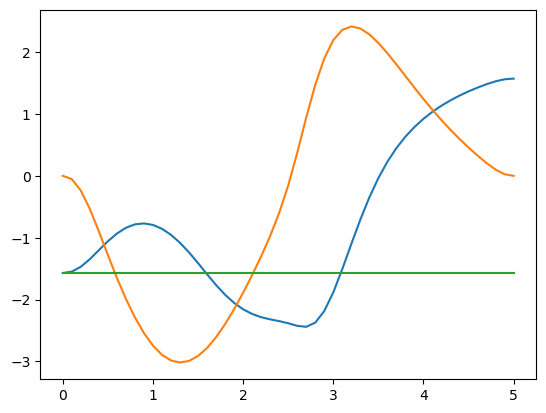

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x14dcbf020>

In [ ]:
# 绘制结果
plot(thist,xtraj[1,:])  # 绘制第一个关节角度
plot(thist,xtraj[2,:])  # 绘制第二个关节角度
plot(thist,xguess[1,:]) # 绘制初始猜测




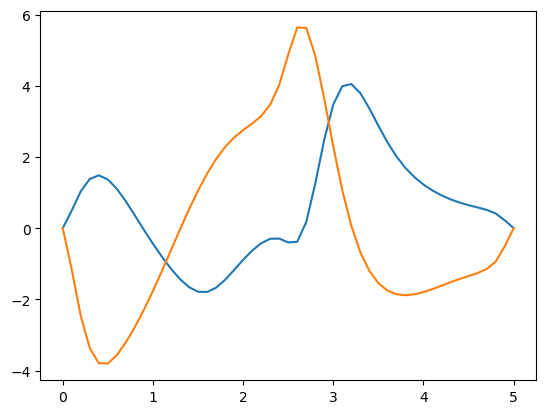

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x166f4bad0>

In [ ]:
plot(thist,xtraj[3,:])  # 绘制第一个关节角速度
plot(thist,xtraj[4,:])  # 绘制第二个关节角速度

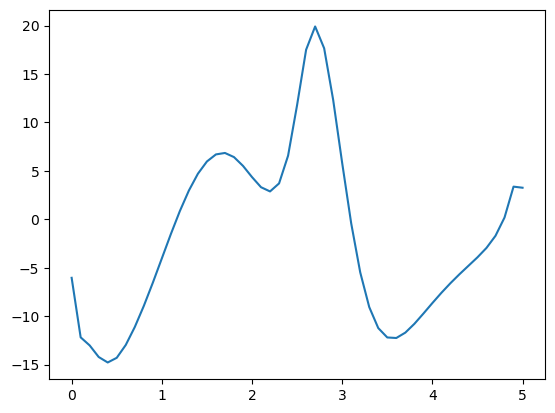

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x166fcc890>

In [ ]:
plot(thist,utraj[1,:])  # 绘制控制输入（扭矩）


In [ ]:
# Acrobot 3D可视化部分
import MeshCat as mc
using Colors

# 绕X轴旋转矩阵
function RotX(alpha)
    c, s = cos(alpha), sin(alpha)
    [1 0 0; 0 c -s; 0 s  c]
end

# 创建Acrobot 3D模型
function create_acrobot!(vis, color=colorant"blue", thick=0.05)
    l1,l2 = [1.,1.]  # 连杆长度
    # 创建关节（圆柱体）
    hinge = mc.Cylinder(mc.Point(-0.05,0,0), mc.Point(0.05,0,0), 0.05)
    # 创建连杆（长方体）
    dim1  = mc.Vec(thick, thick, l1)
    link1 = mc.HyperRectangle(mc.Vec(-thick/2,-thick/2,0),dim1)
    dim2  = mc.Vec(thick, thick, l2)
    link2 = mc.HyperRectangle(mc.Vec(-thick/2,-thick/2,0),dim2)
    # 设置材质
    mat1 = mc.MeshPhongMaterial(color=colorant"grey")
    mat2 = mc.MeshPhongMaterial(color=color)
    # 设置3D对象
    mc.setobject!(vis["base"], hinge, mat1) 
    mc.setobject!(vis["link1"], link1, mat2) 
    mc.setobject!(vis["link1","joint"], hinge, mat1) 
    mc.setobject!(vis["link1","link2"], link2, mat2) 
    # 设置位置变换
    mc.settransform!(vis["link1","link2"], mc.Translation(0,0,l1))
    mc.settransform!(vis["link1","joint"], mc.Translation(0,0,l1))
end

# 更新Acrobot姿态
function update_acro_pose!(vis, x)
    l1, l2 = [1, 1.]
    # 设置第一个连杆的旋转
    mc.settransform!(vis["robot","link1"], mc.LinearMap(RotX(x[1]-pi/2)))
    # 设置第二个连杆的旋转和平移
    mc.settransform!(vis["robot","link1","link2"], mc.compose(mc.Translation(0,0,l1), mc.LinearMap(RotX(x[2]))))
end

# Acrobot动画函数
function animate_acrobot(X, dt)
    vis = mc.Visualizer()                        # 创建可视化器
    create_acrobot!(vis["robot"])                # 创建机器人模型
    anim = mc.Animation(vis, fps=floor(Int,1/dt)) # 创建动画
    for k = 1:length(X)
        mc.atframe(anim, k) do
            update_acro_pose!(vis,X[k])          # 更新每帧的姿态
        end
    end
    mc.setanimation!(vis, anim)                  # 设置动画
    return mc.render(vis)                        # 渲染动画
end


animate_acrobot (generic function with 1 method)

In [ ]:
# 转换状态轨迹格式并播放动画
X1 = [Vector(x) for x in eachcol(xtraj)];  # 将状态轨迹转换为向量数组
animate_acrobot(X1, h)                       # 播放Acrobot运动动画

[ Info: Listening on: 127.0.0.1:8704, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8704


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x62, 0x61, 0x73, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("joint" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8704, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8704), "127.0.0.1", "8704", nothing, Sockets.TCPServer(RawFD(65) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x000000016088cfb0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 4378280288, 2))), MeshCat.AnimationContext[]))